## COMP338 ASS2



### Import package

In [22]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from sklearn.metrics import classification_report

### Test Cuda Cores and set device

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device using: ', device)

Device using:  cuda


### MiniVGGNet with Dropout 

Use resource from when build the function: https://pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/
                                           https://github.com/khanhnamle1994/fashion-mnist/blob/master/CNN-4Conv.ipynb
                                           https://github.com/matvi/miniVGGNet


In [16]:
class MiniVGGNet(nn.Module):
    def __init__(self, inputShape, classes):
        super(MiniVGGNet, self).__init__()

        # Initialize the channel dimension, this will be used for batch normalization.
        chanDim = 1 if inputShape[0] == 1 else 3

        # First set of CONV => RELU => CONV => RELU => POOL layers
        # This set of layers has 32 filters and uses 'same' padding to preserve spatial dimensions.
        self.conv1a = nn.Conv2d(inputShape[0], 32, (3, 3), padding="same")
        self.bn1a = nn.BatchNorm2d(32)
        self.conv1b = nn.Conv2d(32, 32, (3, 3), padding="same")
        self.bn1b = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Pooling to reduce spatial dimensions
        self.dropout1 = nn.Dropout(0.25)  # Dropout for regularization

        # Second set of CONV => RELU => CONV => RELU => POOL layers
        # Increasing the number of filters to 64 for deeper feature extraction.
        self.conv2a = nn.Conv2d(32, 64, (3, 3), padding="same")
        self.bn2a = nn.BatchNorm2d(64)
        self.conv2b = nn.Conv2d(64, 64, (3, 3), padding="same")
        self.bn2b = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # Further reducing dimensions
        self.dropout2 = nn.Dropout(0.25)  # Additional dropout

        # First (and only) set of FC => RELU layers
        # The feature map is flattened and fed into fully connected layers.
        self.fc1 = nn.Linear(64 * (inputShape[1] // 4) * (inputShape[2] // 4), 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(0.5)  # Dropout to prevent overfitting

        # Final softmax classifier that outputs probability distributions over the classes.
        self.fc2 = nn.Linear(512, classes)

    def forward(self, x):
        # Applying the first set of layers followed by activation, batch normalization, and pooling
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Applying the second set of layers with the same pattern as above
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Flatten the convolutional layer's output to feed it into the fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc1(x)

        # Output layer with a softmax to obtain probabilities for each class
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


### MiniVGGNet without Dropout 

In [17]:
# class MiniVGGNet(nn.Module):
#     def __init__(self, inputShape, classes):
#         super(MiniVGGNet, self).__init__()
# 
#         # Initialize the channel dimension for batch normalization
#         chanDim = 1 if inputShape[0] == 1 else 3
# 
#         # First set of CONV => RELU => CONV => RELU => POOL layers
#         self.conv1a = nn.Conv2d(inputShape[0], 32, (3, 3), padding="same")
#         self.bn1a = nn.BatchNorm2d(32)
#         self.conv1b = nn.Conv2d(32, 32, (3, 3), padding="same")
#         self.bn1b = nn.BatchNorm2d(32)
#         self.pool1 = nn.MaxPool2d(kernel_size=2)  # Pooling to reduce spatial dimensions
# 
#         # Second set of CONV => RELU => CONV => RELU => POOL layers
#         self.conv2a = nn.Conv2d(32, 64, (3, 3), padding="same")
#         self.bn2a = nn.BatchNorm2d(64)
#         self.conv2b = nn.Conv2d(64, 64, (3, 3), padding="same")
#         self.bn2b = nn.BatchNorm2d(64)
#         self.pool2 = nn.MaxPool2d(kernel_size=2)  # Further reducing dimensions
# 
#         # Fully connected layers
#         self.fc1 = nn.Linear(64 * (inputShape[1] // 4) * (inputShape[2] // 4), 512)
#         self.bn_fc1 = nn.BatchNorm1d(512)
# 
#         # Final softmax classifier
#         self.fc2 = nn.Linear(512, classes)
# 
#     def forward(self, x):
#         # Applying the first set of layers followed by activation, batch normalization, and pooling
#         x = F.relu(self.bn1a(self.conv1a(x)))
#         x = F.relu(self.bn1b(self.conv1b(x)))
#         x = self.pool1(x)
# 
#         # Applying the second set of layers
#         x = F.relu(self.bn2a(self.conv2a(x)))
#         x = F.relu(self.bn2b(self.conv2b(x)))
#         x = self.pool2(x)
# 
#         # Flatten the output and apply the fully connected layers
#         x = x.view(x.size(0), -1)
#         x = F.relu(self.bn_fc1(self.fc1(x)))
# 
#         # Output layer with a softmax
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1)

### Function Used for Data Loading, Training and Testing

In [23]:
import numpy as np


def calculate_loss_and_accuracy(model_f, data_loader):
    model_f.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model_f(data)
            loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    loss /= len(data_loader)
    accuracy = 100. * correct / total
    return loss, accuracy


def load_data_and_transform(train_batch_size, test_batch_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

    test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    return train_loader, test_loader


def train_model(model_f, train_loader_f, test_loader_f, epochs_f):
    for epoch in epochs_f:
        model_f.train()  # Set the model to training mode
        train_loss = 0  # Initialize the loss for this epoch

        # Iterate over the training data
        with tqdm(train_loader_f, unit="batch") as tepoch:
            for data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch + 1}")
                # Move data to the appropriate device 
                data, target = data.to(device), target.to(device)
                # Zero the gradients before the forward pass
                optimizer.zero_grad()
                # Forward pass: compute the output of the model
                output = model_f(data)
                # Compute the loss
                loss = criterion(output, target)
                # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
                loss.backward()
                # Perform a single optimization step (parameter update)
                optimizer.step()
                # Accumulate the training loss
                train_loss += loss.item()

        # Calculate and record training loss and accuracy
        train_loss, train_accuracy = calculate_loss_and_accuracy(model_f, train_loader_f)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f'End of Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')

        # Record the training metrics to TensorBoard
        writer.add_scalar('Training Loss', train_loss, epoch)
        writer.add_scalar('Training Accuracy', train_accuracy, epoch)

        # Calculate and record test loss and accuracy
        test_loss, test_accuracy = calculate_loss_and_accuracy(model_f, test_loader_f)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f'End of Epoch {epoch + 1}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # Record the test metrics to TensorBoard
        writer.add_scalar('Test Loss', test_loss, epoch)
        writer.add_scalar('Test Accuracy', test_accuracy, epoch)
    return model_f


def test_and_plot_incorrect(model_f, test_loader_f, num_classes, num_images=9):
    model_f.eval()  # Switch model to evaluation mode
    test_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation
        for data, target in tqdm(test_loader_f, desc="Test"):
            data, target = data.to(device), target.to(device)
            output = model_f(data)

            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_predictions.extend(pred.view_as(target).cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader_f.dataset)

    # Print test results
    print(
        f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader_f.dataset)} ({100. * correct / len(test_loader_f.dataset):.2f}%)')

    # Generate and print the classification report
    target_names = ["Class {}".format(i) for i in range(num_classes)]
    print(classification_report(all_targets, all_predictions, target_names=target_names))

    # Identify incorrect predictions
    incorrect_indices = np.nonzero(np.array(all_predictions) != np.array(all_targets))[0]

    # Plot incorrect predictions
    if len(incorrect_indices) > 0:
        plt.figure(figsize=(10, 10))
        for i in range(min(num_images, len(incorrect_indices))):
            idx = incorrect_indices[i]
            plt.subplot(3, 3, i + 1)
            plt.imshow(test_loader_f.dataset[idx][0].squeeze(), cmap='gray', interpolation='none')
            plt.title(f"Predicted: {all_predictions[idx]}, True: {all_targets[idx]}")
            plt.tight_layout()
        plt.show()
    else:
        print("No incorrect predictions to display.")



def polt_for_train_test(epochs_f, train_losses_f, train_accuracies_f, test_losses_f, test_accuracies_f):
    # Plot Training and Test Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_f, train_accuracies_f, 'bo-', label='Train Accuracy')
    plt.plot(epochs_f, test_accuracies_f, 'ro-', label='Test Accuracy')
    plt.title('Training and Test Accuracy(%)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100)  # Ensure y-axis starts at 0 and ends at 100
    plt.legend()  # Include a legend to differentiate between train and test lines
    plt.show()

    # Plot Training and Test Loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_f, train_losses_f, 'bo-', label='Train Loss')
    plt.plot(epochs_f, test_losses_f, 'ro-', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 5)  # Ensure y-axis starts at 0 and ends at 5
    plt.legend()  # Include a legend for clarity
    plt.show()


### Instantiate the model and define the loss function and optimizer

In [19]:
# Instantiate the model
input_shape = (1, 28, 28)  # The image dimensions for the Fashion MNIST dataset
num_classes = 10  # The number of classes in the Fashion MNIST dataset
model = MiniVGGNet(input_shape, num_classes).to(device)  # Move the model to the appropriate device (CPU or GPU)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss is commonly used for classification tasks
optimizer = Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

### Train the model

In [21]:
# Start a writer to store train log
writer = SummaryWriter('runs/fashion_mnist_experiment2')

# Initialize lists to store metrics
train_accuracies = []  # List to store training accuracy per epoch
test_accuracies = []  # List to store test accuracy per epoch
train_losses = []  # List to store training loss per epoch
test_losses = []  # List to store test loss per epoch

# Set epochs
epochs = range(0, 30)
#Load data and set batch size
train_loader, test_loader = load_data_and_transform(train_batch_size=512, test_batch_size=1000)
model = train_model(model, train_loader, test_loader, epochs)

# Create a dummy input tensor that matches the model's input dimensions
dummy_input = torch.zeros(1, *input_shape).to(device)

# Add the model graph to TensorBoard
writer.add_graph(model, dummy_input)

# Close the SummaryWriter
writer.close()

# Save the model to a file
torch.save(model, 'model/MiniVGGNet2.pth')


Epoch 1: 100%|██████████| 118/118 [00:05<00:00, 23.05batch/s]


End of Epoch 1, Training Loss: 0.1680, Training Accuracy: 93.97%
End of Epoch 1, Test Loss: 0.2411, Test Accuracy: 91.06%


Epoch 2: 100%|██████████| 118/118 [00:05<00:00, 22.93batch/s]


End of Epoch 2, Training Loss: 0.1325, Training Accuracy: 95.14%
End of Epoch 2, Test Loss: 0.2325, Test Accuracy: 91.93%


Epoch 3: 100%|██████████| 118/118 [00:05<00:00, 23.59batch/s]


End of Epoch 3, Training Loss: 0.1264, Training Accuracy: 95.34%
End of Epoch 3, Test Loss: 0.2740, Test Accuracy: 90.84%


Epoch 4: 100%|██████████| 118/118 [00:11<00:00, 10.14batch/s]


End of Epoch 4, Training Loss: 0.0713, Training Accuracy: 97.48%
End of Epoch 4, Test Loss: 0.2483, Test Accuracy: 91.94%


Epoch 5: 100%|██████████| 118/118 [00:11<00:00, 10.04batch/s]


End of Epoch 5, Training Loss: 0.0474, Training Accuracy: 98.40%
End of Epoch 5, Test Loss: 0.2449, Test Accuracy: 92.25%


Epoch 6: 100%|██████████| 118/118 [00:05<00:00, 23.30batch/s]


End of Epoch 6, Training Loss: 0.0451, Training Accuracy: 98.52%
End of Epoch 6, Test Loss: 0.2717, Test Accuracy: 91.81%


Epoch 7: 100%|██████████| 118/118 [00:04<00:00, 23.78batch/s]


End of Epoch 7, Training Loss: 0.0323, Training Accuracy: 98.85%
End of Epoch 7, Test Loss: 0.3058, Test Accuracy: 92.28%


Epoch 8: 100%|██████████| 118/118 [00:11<00:00, 10.68batch/s]


End of Epoch 8, Training Loss: 0.0161, Training Accuracy: 99.55%
End of Epoch 8, Test Loss: 0.2960, Test Accuracy: 92.32%


Epoch 9: 100%|██████████| 118/118 [00:05<00:00, 22.42batch/s]


End of Epoch 9, Training Loss: 0.0141, Training Accuracy: 99.60%
End of Epoch 9, Test Loss: 0.3090, Test Accuracy: 92.20%


Epoch 10: 100%|██████████| 118/118 [00:11<00:00,  9.94batch/s]


End of Epoch 10, Training Loss: 0.0196, Training Accuracy: 99.41%
End of Epoch 10, Test Loss: 0.3061, Test Accuracy: 92.18%


Epoch 11: 100%|██████████| 118/118 [00:11<00:00, 10.28batch/s]


End of Epoch 11, Training Loss: 0.0148, Training Accuracy: 99.56%
End of Epoch 11, Test Loss: 0.3251, Test Accuracy: 92.19%


Epoch 12: 100%|██████████| 118/118 [00:04<00:00, 23.90batch/s]


End of Epoch 12, Training Loss: 0.0121, Training Accuracy: 99.62%
End of Epoch 12, Test Loss: 0.3476, Test Accuracy: 92.26%


Epoch 13: 100%|██████████| 118/118 [00:05<00:00, 22.31batch/s]


End of Epoch 13, Training Loss: 0.0082, Training Accuracy: 99.81%
End of Epoch 13, Test Loss: 0.3269, Test Accuracy: 92.51%


Epoch 14: 100%|██████████| 118/118 [00:04<00:00, 23.71batch/s]


End of Epoch 14, Training Loss: 0.0136, Training Accuracy: 99.58%
End of Epoch 14, Test Loss: 0.3242, Test Accuracy: 92.53%


Epoch 15: 100%|██████████| 118/118 [00:04<00:00, 23.65batch/s]


End of Epoch 15, Training Loss: 0.0150, Training Accuracy: 99.53%
End of Epoch 15, Test Loss: 0.3507, Test Accuracy: 92.16%


Epoch 16: 100%|██████████| 118/118 [00:07<00:00, 16.19batch/s]


End of Epoch 16, Training Loss: 0.0091, Training Accuracy: 99.75%
End of Epoch 16, Test Loss: 0.3370, Test Accuracy: 92.44%


Epoch 17: 100%|██████████| 118/118 [00:11<00:00,  9.91batch/s]


End of Epoch 17, Training Loss: 0.0201, Training Accuracy: 99.31%
End of Epoch 17, Test Loss: 0.3811, Test Accuracy: 91.81%


Epoch 18: 100%|██████████| 118/118 [00:10<00:00, 11.11batch/s]


End of Epoch 18, Training Loss: 0.0068, Training Accuracy: 99.81%
End of Epoch 18, Test Loss: 0.3546, Test Accuracy: 92.33%


Epoch 19: 100%|██████████| 118/118 [00:05<00:00, 23.28batch/s]


End of Epoch 19, Training Loss: 0.0037, Training Accuracy: 99.93%
End of Epoch 19, Test Loss: 0.3245, Test Accuracy: 93.00%


Epoch 20: 100%|██████████| 118/118 [00:04<00:00, 23.69batch/s]


End of Epoch 20, Training Loss: 0.0062, Training Accuracy: 99.83%
End of Epoch 20, Test Loss: 0.3485, Test Accuracy: 92.83%


Epoch 21: 100%|██████████| 118/118 [00:11<00:00, 10.27batch/s]


End of Epoch 21, Training Loss: 0.0013, Training Accuracy: 99.98%
End of Epoch 21, Test Loss: 0.3471, Test Accuracy: 92.99%


Epoch 22: 100%|██████████| 118/118 [00:11<00:00, 10.03batch/s]


End of Epoch 22, Training Loss: 0.0009, Training Accuracy: 99.99%
End of Epoch 22, Test Loss: 0.3608, Test Accuracy: 93.00%


Epoch 23: 100%|██████████| 118/118 [00:11<00:00,  9.96batch/s]


End of Epoch 23, Training Loss: 0.0005, Training Accuracy: 99.99%
End of Epoch 23, Test Loss: 0.3537, Test Accuracy: 93.08%


Epoch 24: 100%|██████████| 118/118 [00:11<00:00, 10.30batch/s]


End of Epoch 24, Training Loss: 0.0001, Training Accuracy: 100.00%
End of Epoch 24, Test Loss: 0.3538, Test Accuracy: 93.45%


Epoch 25: 100%|██████████| 118/118 [00:11<00:00, 10.03batch/s]


End of Epoch 25, Training Loss: 0.0001, Training Accuracy: 100.00%
End of Epoch 25, Test Loss: 0.3586, Test Accuracy: 93.44%


Epoch 26: 100%|██████████| 118/118 [00:10<00:00, 10.75batch/s]


End of Epoch 26, Training Loss: 0.0001, Training Accuracy: 100.00%
End of Epoch 26, Test Loss: 0.3603, Test Accuracy: 93.47%


Epoch 27: 100%|██████████| 118/118 [00:04<00:00, 23.96batch/s]


End of Epoch 27, Training Loss: 0.0001, Training Accuracy: 100.00%
End of Epoch 27, Test Loss: 0.3650, Test Accuracy: 93.38%


Epoch 28: 100%|██████████| 118/118 [00:04<00:00, 23.67batch/s]


End of Epoch 28, Training Loss: 0.0001, Training Accuracy: 100.00%
End of Epoch 28, Test Loss: 0.3672, Test Accuracy: 93.35%


Epoch 29: 100%|██████████| 118/118 [00:04<00:00, 23.92batch/s]


End of Epoch 29, Training Loss: 0.0001, Training Accuracy: 100.00%
End of Epoch 29, Test Loss: 0.3692, Test Accuracy: 93.40%


Epoch 30: 100%|██████████| 118/118 [00:04<00:00, 23.97batch/s]


End of Epoch 30, Training Loss: 0.0001, Training Accuracy: 100.00%
End of Epoch 30, Test Loss: 0.3713, Test Accuracy: 93.45%


###  Test the model and plot incorrect prediction

Use resource from when build the function: https://github.com/khanhnamle1994/fashion-mnist/blob/master/CNN-4Conv.ipynb

Test: 100%|██████████| 10/10 [00:00<00:00, 13.66it/s]
C:\Users\Yulin\AppData\Local\Temp\ipykernel_33716\3289703704.py:123: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Test set: Average loss: 0.0004, Accuracy: 9345/10000 (93.45%)
              precision    recall  f1-score   support

     Class 0       0.88      0.90      0.89      1000
     Class 1       0.99      0.99      0.99      1000
     Class 2       0.91      0.91      0.91      1000
     Class 3       0.93      0.93      0.93      1000
     Class 4       0.90      0.91      0.90      1000
     Class 5       0.98      0.98      0.98      1000
     Class 6       0.82      0.79      0.80      1000
     Class 7       0.96      0.98      0.97      1000
     Class 8       0.98      0.99      0.99      1000
     Class 9       0.98      0.97      0.98      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


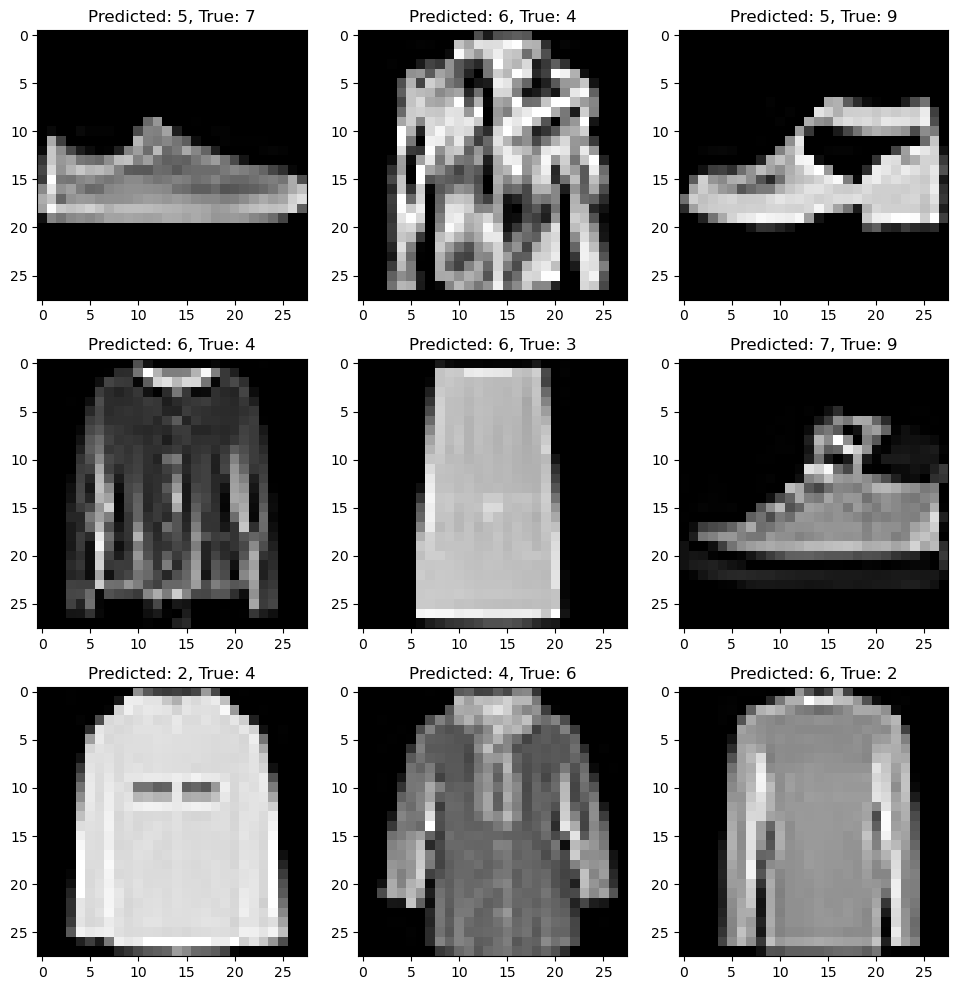

In [27]:
# Load model from local
model = torch.load('model/MiniVGGNet2.pth')

# Evaluate the model
test_and_plot_incorrect(model, test_loader,10)

### Plot the accuracy and loss for training and testing

In [ ]:
polt_for_train_test(epochs, train_losses, train_accuracies, test_losses, test_accuracies)

### Model Summary

In [13]:
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
            Conv2d-3           [-1, 32, 28, 28]           9,248
       BatchNorm2d-4           [-1, 32, 28, 28]              64
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6           [-1, 64, 14, 14]          18,496
       BatchNorm2d-7           [-1, 64, 14, 14]             128
            Conv2d-8           [-1, 64, 14, 14]          36,928
       BatchNorm2d-9           [-1, 64, 14, 14]             128
        MaxPool2d-10             [-1, 64, 7, 7]               0
           Linear-11                  [-1, 512]       1,606,144
      BatchNorm1d-12                  [-1, 512]           1,024
           Linear-13                   [-1, 10]           5,130
Total params: 1,677,674
Trainable param